In [1]:
# Downloads import-ipynb
import sys
from IPython.utils.io import capture_output

with capture_output() as captured:
    !{sys.executable} -m pip install import-ipynb

In [2]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import r_regression
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import import_ipynb
import common_functions

importing Jupyter notebook from common_functions.ipynb


## Functions (unique to this task)

In [3]:
def select_top_features(x_train, y_train, num_features=10):
    '''
    Computes Pearson Correlation Coefficient values for the features
    and selects the top 'num_features' number of features.
    Parameters:
    - x_train: Training dataset
    - y_train: Training dataset
    - num_features: Number of top features to select
    '''
    correlation_coefficients = r_regression(x_train, y_train)
    top_features_indices = np.argsort(np.abs(correlation_coefficients))[-num_features:][::-1]
    return top_features_indices, correlation_coefficients

In [4]:
def plot_feature_importance(correlation_coefficients, top_features_indices):
    '''
    Plots feature importance bar chart
    Parameters:
    - correlation_coefficients - Coefficient values for the features
    - top_feature_indices - Indices of the top features
    '''
    
    # Gets the coefficient values for the features
    values = np.abs(correlation_coefficients[top_features_indices])
    
    # Creates the plot
    plt.figure(figsize=(10, 5))
    bars = plt.bar(range(len(top_features_indices)), values)
    
    # Adds value labels to each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')
        
    # Sets the labels and title
    plt.xlabel('Feature Index')
    plt.ylabel('Absolute Correlation Coefficient')
    plt.title('Top 10 Feature Importance Based on Pearson Correlation')
    plt.xticks(range(len(top_features_indices)), labels=[str(idx) for idx in top_features_indices])
    plt.show()

To refrain from having excessively long run-times, the different values for kernels in the SVC function (within the function below) were tested while working on this task, and **'rbf'** was decided with as the best performing kernel hyperparameter value. Therefore, the initialized model will be tested for different values of the **C** and **Gamma** hyperparameters.

In [5]:
def train_evaluate_svm(x_train, y_train, x_test, y_test, C_values, gamma_values, n_splits=10):
    '''
    Trains and evaluates an SVC classifier using stratified K-fold cross validation.
    Different combinations of hyperparameters are experimented with, and the best configuration is returned.
    
    Parameters:
        - x_train: Training data (Features)
        - y_train: Training data (Labels)
        - x_test: Testing data (Features)
        - y_test: Testing data (Labels)
        - C_values: A list of different possible values for the C Value hyperparameter to be tested
        - gamma_values: A list of different possible values for the C Value hyperparameter to be tested
        - n_splits: Number of folds for the k-fold cross validation
        
    Returns:
        - best_params: The best performing parameters based on test set accuracy
    '''
    
    # Validates that C_values and gamma_values are both passed
    if not C_values or not gamma_values:
        raise ValueError("Both C_values and gamma_values must be passed to the function.")
    
    # Initializes the stratified cross validator
    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Dictionary to store evaluation metrics
    results = {
        "Testing Accuracy": [],
        "Training Accuracy": [],
        "F1": [],
        "Precision": [],
        "Recall": []
    }
    
    best_accuracy = 0
    best_params = {'C': None, 'gamma': None}

    # Loops through different hyperparameter values to find the ideal configuration
    for C in C_values:
        for gamma in gamma_values:
            # Logs the configuration being currently tested
            print('-'*30)
            print("Training and evaluating model using C={} and gamma={}".format(C, gamma))
            
            # Loop over to perform cross validation
            for train_idx, test_idx in kfold.split(x_train, y_train):
                x_train_fold, x_test_fold = x_train[train_idx], x_train[test_idx]
                y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

                # Scales the features for each fold
                x_train_scaled, x_test_scaled, _ = common_functions.scale_data(x_train_fold, x_test_fold)
                
                # Initializes and fits the SVC model with the passed hyperparameters
                svm_classifier = SVC(kernel='rbf', C=C, gamma=gamma, probability=True, class_weight='balanced')
                svm_classifier.fit(x_train_scaled, y_train_fold)
                
                # Generates predictions
                predictions = svm_classifier.predict(x_test_scaled)
                training_predictions = svm_classifier.predict(x_train_scaled)
                
                # Computes evaluation metrics
                accuracy = accuracy_score(y_test_fold, predictions)
                training_accuracy = accuracy_score(y_train_fold, training_predictions)
                precision, recall, f1, _ = precision_recall_fscore_support(y_test_fold, predictions, average='macro', zero_division=0)

                # Stores results
                results["Testing Accuracy"].append(accuracy)
                results["Training Accuracy"].append(training_accuracy)
                results["F1"].append(f1)
                results["Precision"].append(precision)
                results["Recall"].append(recall)
                
            # Displays averages of the results for each computed metric
            for metric, scores in results.items():
                if metric == 'Testing Accuracy':
                    avg_accuracy = np.mean(scores)
                print(f'{metric}: {np.mean(scores):.2f} ± {np.std(scores):.2f}')
            print('-'*30)

            # Updates best params if current config outperforms the previous ones
            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_params = {'C': C, 'gamma': gamma}

    return best_params

## Loading of Data and Selection of Features

x_train - Total NaNs: 0, Total Infs: 0
x_test - Total NaNs: 0, Total Infs: 0


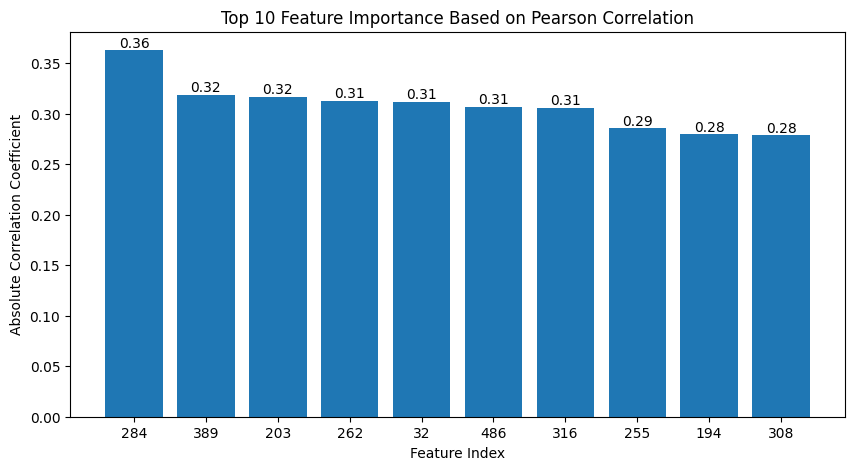

In [6]:
# Loads and stores the data from their respective datasets
x_train, x_test, y_train, y_test = common_functions.load_data()

# Gets the indices and correlation coefficients of the top 10 features using Pearsons Correlation
top_features_indices, correlation_coefficients = select_top_features(x_train, y_train)

# Plots a bar graph of the top 10 features
plot_feature_importance(correlation_coefficients, top_features_indices)

## Selection and Scaling of Data

In [7]:
# Narrows down data based on selected features
x_train_selected = x_train[:, top_features_indices]
x_test_selected = x_test[:, top_features_indices]

# Scales the data (for the final model)
x_train_scaled, x_test_scaled, _ = common_functions.scale_data(x_train_selected, x_test_selected, False)

## Hyperparameter Optimization (Function Execution)

In [8]:
# Hyperparamter defintion (for optimization)
C_values = [100, 0.1, 1, 10, 0.01] 
gamma_values = [0.001, 1, 0.01, 10, 0.1]

# Trains model using passed hyperparameter values
best_params = train_evaluate_svm(
    x_train_selected, y_train, x_test_selected, y_test, C_values, gamma_values
)
print("Best hyperparameters:", best_params)

------------------------------
Training and evaluating model using C=100 and gamma=0.001
Testing Accuracy: 0.65 ± 0.01
Training Accuracy: 0.65 ± 0.00
F1: 0.62 ± 0.01
Precision: 0.63 ± 0.01
Recall: 0.63 ± 0.01
------------------------------
------------------------------
Training and evaluating model using C=100 and gamma=1
Testing Accuracy: 0.63 ± 0.01
Training Accuracy: 0.74 ± 0.09
F1: 0.61 ± 0.01
Precision: 0.61 ± 0.02
Recall: 0.62 ± 0.02
------------------------------
------------------------------
Training and evaluating model using C=100 and gamma=0.01
Testing Accuracy: 0.64 ± 0.02
Training Accuracy: 0.72 ± 0.08
F1: 0.62 ± 0.02
Precision: 0.62 ± 0.02
Recall: 0.63 ± 0.02
------------------------------
------------------------------
Training and evaluating model using C=100 and gamma=10
Testing Accuracy: 0.61 ± 0.07
Training Accuracy: 0.78 ± 0.13
F1: 0.58 ± 0.06
Precision: 0.59 ± 0.06
Recall: 0.59 ± 0.07
------------------------------
------------------------------
Training and eval

## Final Model Initialization and Fitting

In [9]:
# Initializes the model with the best configuration
svm_classifier = SVC(kernel='rbf', **best_params, probability=True)

# Fitting the model and making predictions
svm_classifier.fit(x_train_scaled, y_train)
predictions = svm_classifier.predict(x_test_scaled)
training_predictions = svm_classifier.predict(x_train_scaled)

## Final Model Evaluation

In [10]:
# Computes and displays final model accuracy
accuracy = accuracy_score(y_test, predictions)
training_accuracy = accuracy_score(y_train, training_predictions)
print("Final model training accuracy:", training_accuracy)
print("Final model testing accuracy:", accuracy)

Final model training accuracy: 0.6514197530864198
Final model testing accuracy: 0.6457407407407407


In [11]:
# Computes and displays the classification report for the final model
class_report = classification_report(y_test, predictions, zero_division=0)
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.76      0.74       613
         1.0       0.78      0.84      0.81       605
         2.0       0.68      0.56      0.61       628
         3.0       0.41      0.20      0.27       499
         4.0       0.59      0.71      0.64       507
         5.0       0.45      0.46      0.45       409
         6.0       0.38      0.50      0.44       481
         7.0       0.87      0.86      0.87       583
         8.0       0.50      0.55      0.53       511
         9.0       0.87      0.88      0.88       564

    accuracy                           0.65      5400
   macro avg       0.63      0.63      0.62      5400
weighted avg       0.64      0.65      0.64      5400



## Visualizations

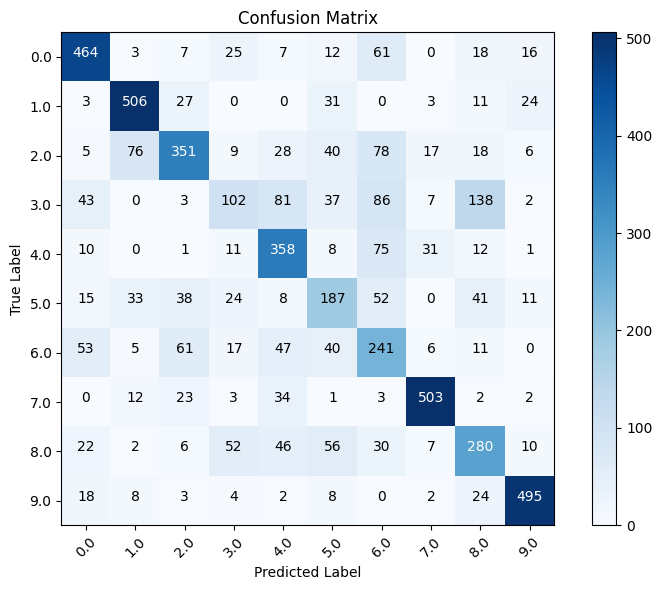

In [12]:
# Plots a confusion matrix
cm_best = confusion_matrix(y_test, predictions)
common_functions.plot_confusion_matrix(cm_best, y_test)

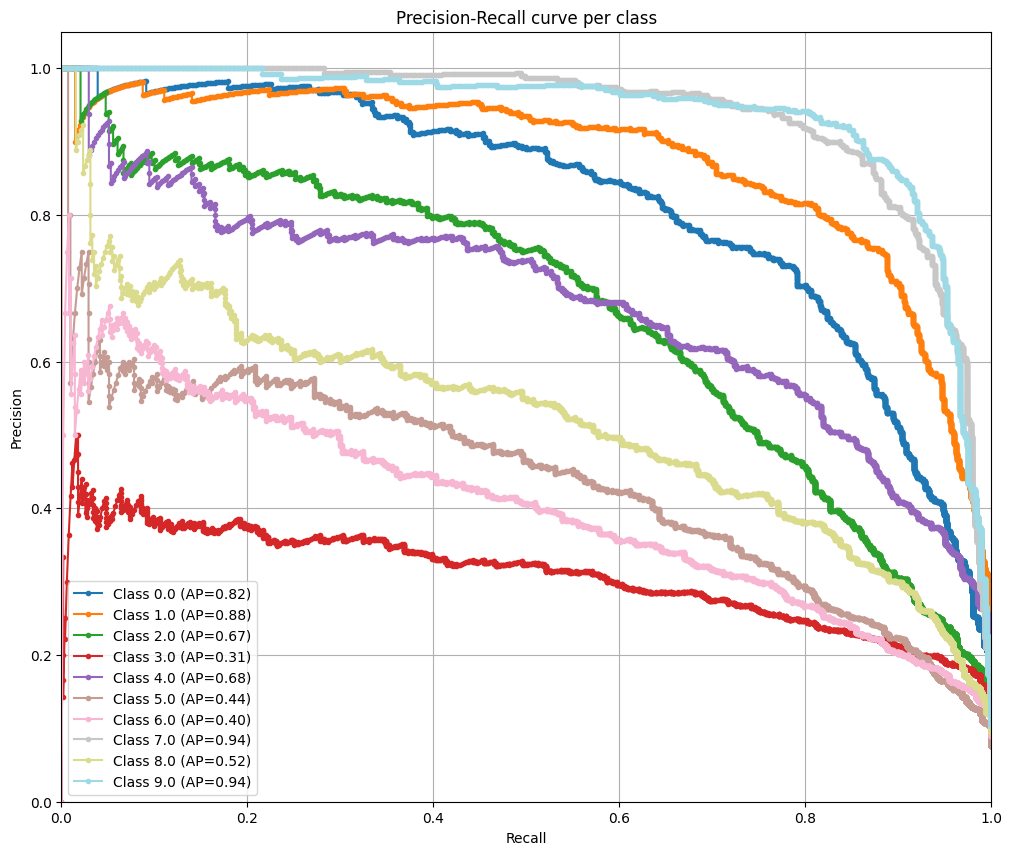

In [13]:
# Generates probability scores to be used for the preicison recall curve
probabilities = svm_classifier.predict_proba(x_test_scaled)
# Plots a precision recall curve for all the 10 classes
common_functions.plot_precision_recall_curve_multiclass(y_test, probabilities, np.unique(y_train))

### Markdown Answer to Question 3.1 ii)

An effective alternative to PCA to reduce the computational complexity when dealing with datasets with a large number of features, would be Incremental PCA (IPCA). In traditional PCA, the entire dataset is loaded into the memory and processed at once, whereas IPCA manages these datasets by processing them in manageable batches. This method updates the principal components iteratively and adapts to new data as it becomes available. By following this methodology, IPCA efficiently handles memory and computational restrictions, typically in large-scale environments. This makes it particularly useful for situations that require real-time analysis. IPCA's ability to approximate traditional PCA results whilst managing resource use simultaneously make it an optimal choice for an alternative to PCA, that provides scalability and practicality.